# torch.nn实现多分类

In [10]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
batch_size = 256
num_workers = 4
lr = 3e-2
num_epochs = 25
gamma = 5e-1 # 用于ELU函数
lamda = 0 # weight_decay 惩罚因子

## 1 获取和读取数据

In [20]:
mnist_train = torchvision.datasets.FashionMNIST(root='./datasets/FashionMNIST/', train=True,
download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='./datasets/FashionMNIST/', train=False,
download=True, transform=transforms.ToTensor())

RuntimeError: File not found or corrupted.

In [214]:
Num = mnist_train.data.shape[0]
mnist_train, mnist_test

(Dataset FashionMNIST
     Number of datapoints: 60000
     Split: train
     Root Location: ./Datasets/MNIST/
     Transforms (if any): ToTensor()
     Target Transforms (if any): None,
 Dataset FashionMNIST
     Number of datapoints: 10000
     Split: test
     Root Location: ./Datasets/MNIST/
     Transforms (if any): ToTensor()
     Target Transforms (if any): None)

In [215]:
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True,
num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, 
num_workers=num_workers)

## K折检验分数据

In [216]:
# _X = torch.cat((mnist_train.data.float(), mnist_test.data.float()), dim=0)
# _y = torch.cat((mnist_train.targets.long(), mnist_test.targets.long()), dim=0)
# _X.shape, _y.shape

In [217]:
# def get_kfold_data(k, i, X, y):
#     # 返回第i + 1 折 (i = 0 -> k - 1) 交叉验证时所需要的训练和验证数据，X_train为训练集，X_test为验证集
#     fold_size = X.shape[0] // k # 每份的个数：数据总条数/折数（组数）
#     val_start = i * fold_size # 计算开始的索引
#     if i != k - 1: # 不是最后一折
#         val_end = (i + 1) * fold_size
#         X_test, y_test = X[val_start:val_end], y[val_start:val_end]
#         X_train = torch.cat((X[:val_start], X[val_end:]), dim=0)
#         y_train = torch.cat((y[:val_start], y[val_end:]), dim=0)
#     else: # 如果选择的是最后一折
#         X_train, y_train = X[:val_start], y[:val_start]
#         X_test, y_test = X[val_start:], y[val_start:]
#     return X_train, X_test, y_train, y_test

In [218]:
# X_train, X_test, y_train, y_test = get_kfold_data(10, 2, _X, _y)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [219]:
# m_train = torch.utils.data.TensorDataset(X_train, y_train)
# m_test = torch.utils.data.TensorDataset(X_test, y_test)

In [220]:
# train_iter = torch.utils.data.DataLoader(m_train, batch_size=batch_size, shuffle=True,
# num_workers=num_workers)
# test_iter = torch.utils.data.DataLoader(m_test, batch_size=batch_size, shuffle=False, 
# num_workers=num_workers)

## 2 定义和初始化模型

In [221]:
num_input = 784
num_output = 10
num_hidden = 512
drop_prob = 0.2

In [237]:
class Net_relu(nn.Module):
    def __init__(self):
        super(Net_relu, self).__init__()
        self.hidden = nn.Linear(num_input, num_hidden)
        self.flatten = nn.Linear(num_hidden, num_output)
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, X):
        layer1_output = self.relu(self.hidden(X.view(-1, num_input)))
        hidden_output = self.dropout(layer1_output)
        layer2_output = self.flatten(hidden_output)
        return self.softmax(layer2_output)
net_relu = Net_relu()
net_relu.forward

<bound method Net_relu.forward of Net_relu(
  (hidden): Linear(in_features=784, out_features=512, bias=True)
  (flatten): Linear(in_features=512, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)>

In [238]:
num_hidden1 = 256
num_hidden2 = 64
drop_prob_group = [0.05, 0.1]
class Net_relu_addlayer(nn.Module):
    def __init__(self):
        super(Net_relu_addlayer, self).__init__()
        self.hidden1 = nn.Linear(num_input, num_hidden1)
        self.hidden2 = nn.Linear(num_hidden1, num_hidden2)
        self.flatten = nn.Linear(num_hidden2, num_output)
        
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=drop_prob_group[0])
        self.dropout2 = nn.Dropout(p=drop_prob_group[1])

    def forward(self, X):
        # 第一层
        layer1_output = self.relu(self.hidden1(X.view(-1, num_input)))
        hidden1_output = self.dropout1(layer1_output)
        # 第二层
        layer2_output = self.relu(self.hidden2(hidden1_output))
        hidden2_output = self.dropout2(layer2_output)
        # 输出层
        layer3_output = self.flatten(hidden2_output)
        return self.softmax(layer2_output)
net = Net_relu_addlayer()
net

Net_relu_addlayer(
  (hidden1): Linear(in_features=784, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=64, bias=True)
  (flatten): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
  (relu): ReLU()
  (dropout1): Dropout(p=0.05, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [224]:
class Net_tanh(nn.Module):
    def __init__(self):
        super(Net_tanh, self).__init__()
        self.hidden = nn.Linear(num_input, num_hidden)
        self.flatten = nn.Linear(num_hidden, num_output)
        self.softmax = nn.Softmax(dim=1)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(p=drop_prob)
        
    def forward(self, X):
        layer1_output = self.tanh(self.hidden(X.view(-1, num_input)))
        hidden_output = self.dropout(layer1_output)
        layer2_output = self.flatten(hidden_output)
        return self.softmax(layer2_output)
    
net_tanh = Net_tanh()

In [225]:
class Net_ELU(nn.Module):
    def __init__(self):
        super(Net_ELU, self).__init__()
        self.hidden = nn.Linear(num_input, num_hidden)
        self.flatten = nn.Linear(num_hidden, num_output)
        self.softmax = nn.Softmax(dim=1)
        self.elu = nn.ELU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, X):
        layer1_output = self.elu(self.hidden(X.view(-1, num_input)))
        hidden_output = self.dropout(layer1_output)
        layer2_output = self.flatten(hidden_output)
        return self.softmax(layer2_output)

net_ELU = Net_ELU()

In [227]:
# Net = Net_ELU()
# Net = Net_tanh()
from torch.nn import init

# Net = Net_relu_addlayer() #废物网络
Net = Net_relu()
Net.train()
for param in Net.parameters():
    init.normal_(param, mean=0, std=0.01)

## 3 定义损失函数

In [228]:
loss = nn.CrossEntropyLoss()

## 4 定义优化算法

In [229]:
import torch.optim as optim
optimizer = optim.SGD(params=Net.parameters(), lr=lr, weight_decay=lamda)

## 5 评估系统

In [230]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        net.eval()
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
        net.train()
    return acc_sum / n

In [231]:
evaluate_accuracy(train_iter, Net)

0.0969

In [232]:
def loss_evl(Iter, net, Datasets):
    l = 0.0
    for X, y in Iter:
        # 验证loss的时候不需要drop
        net.eval()
        y_hat = net(X)
        # 注意这里loss必须都是long型 而通过继承的softmax产生的结果是long型，只有自己准备的y需要转换
        l += loss(y_hat, y).sum().item()
        net.train()
    return l / Datasets.data.shape[0]
#     return l

In [233]:
loss_evl(train_iter, Net, mnist_test)

0.05411596255302429

## 6 训练模型

In [234]:
loss_train = []
loss_test = []
for epoch in range(num_epochs):
    for X, y in train_iter:
        y_hat = Net(X)
        l = loss(y_hat, y).sum()
        optimizer.zero_grad()
        
        l.backward()
        optimizer.step()

#     train_l = loss_evl(train_iter, Net, mnist_train)
    train_l = loss_evl(train_iter, Net, mnist_train)
    loss_train.append(train_l)
    
#     test_l = loss_evl(test_iter, Net, mnist_test)
    test_l = loss_evl(test_iter, Net, mnist_test)
    loss_test.append(test_l)
    
    print("epoch %d: train_loss: %f test_loss: %f "%(epoch + 1, train_l, test_l))  

epoch 1: train_loss: 0.008973 test_loss: 0.009165 
epoch 2: train_loss: 0.008817 test_loss: 0.009005 
epoch 3: train_loss: 0.008298 test_loss: 0.008472 
epoch 4: train_loss: 0.007808 test_loss: 0.007975 
epoch 5: train_loss: 0.007557 test_loss: 0.007720 
epoch 6: train_loss: 0.007384 test_loss: 0.007545 
epoch 7: train_loss: 0.007301 test_loss: 0.007460 
epoch 8: train_loss: 0.007251 test_loss: 0.007409 
epoch 9: train_loss: 0.007205 test_loss: 0.007361 
epoch 10: train_loss: 0.007101 test_loss: 0.007265 
epoch 11: train_loss: 0.007038 test_loss: 0.007207 
epoch 12: train_loss: 0.006985 test_loss: 0.007154 
epoch 13: train_loss: 0.006934 test_loss: 0.007103 
epoch 14: train_loss: 0.006886 test_loss: 0.007051 
epoch 15: train_loss: 0.006841 test_loss: 0.007004 
epoch 16: train_loss: 0.006801 test_loss: 0.006964 
epoch 17: train_loss: 0.006769 test_loss: 0.006931 
epoch 18: train_loss: 0.006742 test_loss: 0.006902 
epoch 19: train_loss: 0.006717 test_loss: 0.006880 
epoch 20: train_loss:

In [235]:
evaluate_accuracy(train_iter, Net), evaluate_accuracy(test_iter, Net)

(0.7872666666666667, 0.7799)

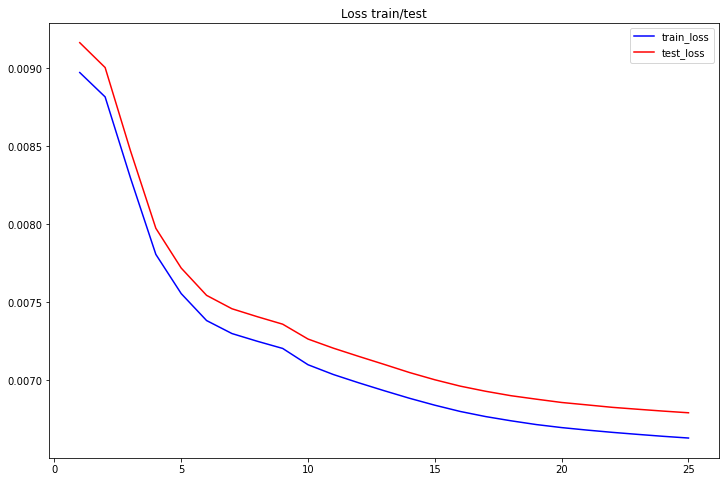

In [236]:
plt.figure(figsize=(12, 8))
plt.title('Loss train/test')
plt.plot(list(range(1, num_epochs + 1)), loss_train, c='b', label='train_loss')
plt.plot(list(range(1, num_epochs + 1)), loss_test, c='r', label='test_loss')
plt.legend(loc=1)

## 特别实验

In [ ]:
def plot(loss_train, loss_test, acc_train, acc_test, loc_idx):
    plt.subplot(3, 2, loc_idx)
    plt.title('Loss train/test')
    plt.plot(list(range(1, num_epochs + 1)), loss_train, c='b', label='train_loss')
    plt.plot(list(range(1, num_epochs + 1)), loss_test, c='r', label='test_loss')
    plt.legend(loc=1)
    plt.subplot(3, 2, loc_idx + 1)
    plt.title('Accuracy train/test')
    plt.plot(list(range(1, num_epochs + 1)), acc_train, c='b', label='acc_train')
    plt.plot(list(range(1, num_epochs + 1)), acc_test, c='r', label='acc_test')
    plt.legend(loc=1)

[ Net_relu(
  (hidden): Linear(in_features=784, out_features=512, bias=True)
  (flatten): Linear(in_features=512, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
) ]
测试前的正确率: 0.068867
[ Net_tanh(
  (hidden): Linear(in_features=784, out_features=512, bias=True)
  (flatten): Linear(in_features=512, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
  (tanh): Tanh()
  (dropout): Dropout(p=0.5, inplace=False)
) ]
测试前的正确率: 0.077083
[ Net_ELU(
  (hidden): Linear(in_features=784, out_features=512, bias=True)
  (flatten): Linear(in_features=512, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
  (elu): ELU(alpha=1.0)
  (dropout): Dropout(p=0.5, inplace=False)
) ]
测试前的正确率: 0.083267


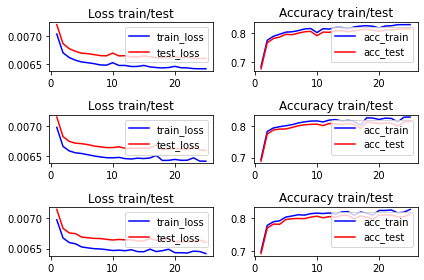

In [20]:
net_group = [0, net_relu, 0, net_tanh, 0, net_ELU]
for idx in [1, 3, 5]:
    Net = net_group[idx]   
    loss_train = []
    loss_test = []
    acc_train = []
    acc_test = []
    # 初始化
    # 隐藏层参数
    from torch.nn import init

    for param in Net.parameters():
        init.normal_(param, mean=0, std=0.01)
        
    import torch.optim as optim
    optimizer = optim.SGD(params=Net.parameters(), lr=lr, weight_decay=lamda)
    
    print("[", Net, "]")
    print("测试前的正确率: %f"%evaluate_accuracy(train_iter, Net))
    for epoch in range(num_epochs):
        Net.eval()
        for X, y in train_iter:
            y_hat = Net(X)
            l = loss(y_hat, y).sum()
            optimizer.zero_grad()

            l.backward()
            optimizer.step()

        train_l = loss_evl(train_iter, Net, mnist_train)
        loss_train.append(train_l)
        train_acc = evaluate_accuracy(train_iter, Net)
        acc_train.append(train_acc)
        test_l = loss_evl(test_iter, Net, mnist_test)
        loss_test.append(test_l)
        test_acc = evaluate_accuracy(test_iter, Net)
        acc_test.append(test_acc)
    plot(loss_train, loss_test, acc_train, acc_test, idx)
plt.tight_layout() 

In [22]:
Net

Net_ELU(
  (hidden): Linear(in_features=784, out_features=512, bias=True)
  (flatten): Linear(in_features=512, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
  (elu): ELU(alpha=1.0)
  (dropout): Dropout(p=0.5, inplace=False)
)